#Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset from the uploaded file
file_path = '/content/drive/MyDrive/MindGuard/data_suicide6k.csv'
df = pd.read_csv(file_path)

#Examine the Distribution of Target Labels

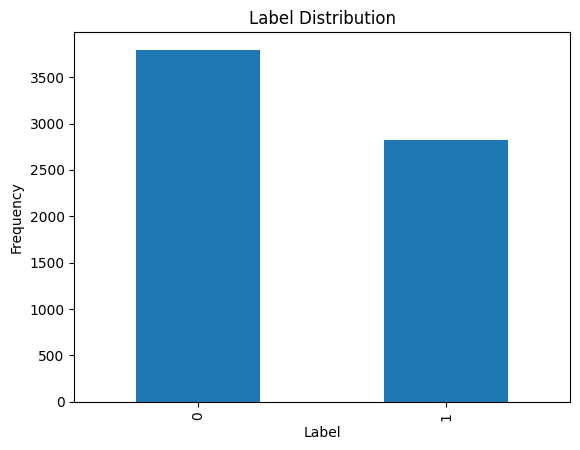

In [ ]:
# Visualize the label distribution
label_counts = df['target'].value_counts()
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

#Preprocess Data

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from cleantext import clean
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = clean(text,
                 no_emoji=True,       # remove emojis
                 no_numbers=True)
    return text

df['text'] = df['text'].apply(clean_text)

stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Tokenization using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
df['tokenized_text'] = df['text'].apply(lambda x: tokenizer.tokenize(x))
df['token_ids'] = df['text'].apply(lambda x: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(x)))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
df.head()

,text,target,tokenized_text,token_ids
0,please comforting word everything mentally hur...,1,"[please, comforting, word, everything, mentall...","[3531, 16334, 2773, 2673, 10597, 3480, 2215, 2..."
1,poem sun taurus moon scorpio kill horny die an...,0,"[poem, sun, tau, ##rus, moon, sc, ##or, ##pio,...","[5961, 3103, 19982, 7946, 4231, 8040, 2953, 22..."
2,tried everything medication hospital psychiatr...,1,"[tried, everything, medication, hospital, psyc...","[2699, 2673, 14667, 2902, 18146, 15034, 2424, ..."
3,uselessi preface fact asperger cannot function...,1,"[useless, ##i, preface, fact, as, ##per, ##ger...","[11809, 2072, 18443, 2755, 2004, 4842, 4590, 3..."
4,rlly random anyone play cold war xbox youtube ...,0,"[r, ##lly, random, anyone, play, cold, war, xb...","[1054, 9215, 6721, 3087, 2377, 3147, 2162, 122..."


#Split Dataset Into Training and Validation Sets

In [ ]:
import torch
import csv
import os
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import sparse_categorical_crossentropy
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.optim.lr_scheduler import StepLR

### Dataset Class for Suicidal Sentiment Analysis

In [ ]:
class SuicidalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.4, stratify=df['target'], random_state=42)

# Tokenizer and dataset preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256
train_dataset = SuicidalDataset(train_df['text'].to_numpy(), train_df['target'].to_numpy(), tokenizer, max_len)
val_dataset = SuicidalDataset(val_df['text'].to_numpy(), val_df['target'].to_numpy(), tokenizer, max_len)

# DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#converts all words into vectors
# Model and optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#CSV file to save the metrics at each epoch
metrics_file = 'training_metrics.csv'

# Header
header = ['Epoch', 'Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy', 'Precision', 'Recall', 'F1 Score']

with open(metrics_file, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=header)
    writer.writeheader()

epoch_metrics = {'Epoch': 1, 'Training Loss': 0.1, 'Training Accuracy': 0.9,
                 'Validation Loss': 0.05, 'Validation Accuracy': 0.95,
                 'Precision': 0.92, 'Recall': 0.88, 'F1 Score': 0.90}

with open(metrics_file, 'a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=header)
    writer.writerow(epoch_metrics)

In [ ]:
def calculate_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    return accuracy, precision, recall, f1

#Training Model
## Heads Up: Take in mind that this training was done on pretrained model of our own so we only trained it on 5 more epoches

In [ ]:
# Initialize metrics file
metrics_file = 'training_metrics.csv'
with open(metrics_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Function to calculate metrics
def calculate_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0 )
    return accuracy, precision, recall, f1

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
epochs = 5


for epoch in range(epochs):
    model.train()
    total_loss, total_accuracy = 0, 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        temp_accuracy, _, _, _ = calculate_metrics(logits, label_ids)
        total_accuracy += temp_accuracy

    avg_train_loss = total_loss / len(train_dataloader)
    avg_train_accuracy = total_accuracy / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}, Training Accuracy: {avg_train_accuracy}")

    # Validation
    model.eval()
    total_val_loss, total_val_accuracy, total_precision, total_recall, total_f1 = 0, 0, 0, 0, 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            temp_accuracy, temp_precision, temp_recall, temp_f1 = calculate_metrics(logits, label_ids)
            total_val_accuracy += temp_accuracy
            total_precision += temp_precision
            total_recall += temp_recall
            total_f1 += temp_f1

    avg_val_accuracy = total_val_accuracy / len(val_dataloader)
    avg_precision = total_precision / len(val_dataloader)
    avg_recall = total_recall / len(val_dataloader)
    avg_f1 = total_f1 / len(val_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}, F1 Score: {avg_f1}")

    # Save metrics to CSV
    with open(metrics_file, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, avg_train_loss, avg_train_accuracy, avg_val_loss, avg_val_accuracy, avg_precision, avg_recall, avg_f1])

    # Adjust learning rate
    scheduler.step()

Epoch 1/5, Training Loss: 0.2419683397484703, Training Accuracy: 0.9173387096774194
Epoch 1/5, Validation Loss: 0.13582464492128019, Validation Accuracy: 0.963855421686747, Precision: 0.938205419078913, Recall: 0.9836295398042387, F1 Score: 0.9568752448854766


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 2/5, Training Loss: 0.09237629104773665, Training Accuracy: 0.9758064516129032
Epoch 2/5, Validation Loss: 0.09827017313408026, Validation Accuracy: 0.9740210843373494, Precision: 0.9742324275456806, Recall: 0.9587610180983679, F1 Score: 0.9637223465937704
Epoch 3/5, Training Loss: 0.047478399156628465, Training Accuracy: 0.9901713709677419
Epoch 3/5, Validation Loss: 0.15120188403890064, Validation Accuracy: 0.9732680722891566, Precision: 0.980602931205341, Recall: 0.9509681583476768, F1 Score: 0.9622975976165691
Epoch 4/5, Training Loss: 0.026583558194033685, Training Accuracy: 0.9939516129032258
Epoch 4/5, Validation Loss: 0.10636952269246594, Validation Accuracy: 0.9725150602409639, Precision: 0.9481503937829239, Recall: 0.9879374641422835, F1 Score: 0.9646591296360517
Epoch 5/5, Training Loss: 0.009092588249146619, Training Accuracy: 0.9982358870967742
Epoch 5/5, Validation Loss: 0.1708545922180188, Validation Accuracy: 0.9755271084337349, Precision: 0.9832950851023141, Reca

###Saving and Loading

In [ ]:
# Save the model
model_save_path = "/content/drive/MyDrive/MindGuard/the_new_model.pt"
torch.save(model.state_dict(), model_save_path)

In [ ]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/MindGuard/The_Golden.pt"))
model= model.to(device)

#Testing and Predicting

In [ ]:
def predict_and_save(text, model, tokenizer, max_len, file_path):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        return_attention_mask=True,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**inputs.to(model.device))
        prediction = torch.argmax(outputs.logits, dim=1).item()

    # Append the text and prediction to the CSV file
    with open(file_path, 'a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow([text, prediction])

    return prediction

# File path for the CSV
csv_file_path = 'predictions.csv'

# Example usage
sample_text = "I want to die "
prediction = predict_and_save(sample_text, model, tokenizer, max_len=256, file_path=csv_file_path)
print("Prediction:", prediction)


Prediction: 1


#More testing Examples

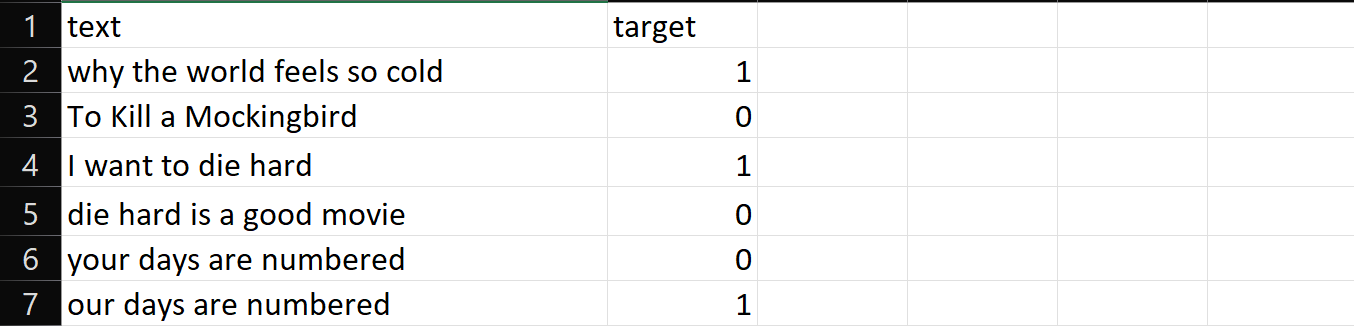

#HyperTuning

In [ ]:
def create_dataloaders(train_df, val_df, batch_size, tokenizer, max_len):
    # Convert DataFrame into SuicidalDataset
    train_dataset = SuicidalDataset(train_df['text'].to_numpy(), train_df['target'].to_numpy(), tokenizer, max_len)
    val_dataset = SuicidalDataset(val_df['text'].to_numpy(), val_df['target'].to_numpy(), tokenizer, max_len)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, epochs, device):
    best_val_accuracy = 0.0
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_dataloader)

        # Validation phase
        model.eval()
        total_val_accuracy = 0
        total_val_loss = 0
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits
                total_val_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            preds = np.argmax(logits, axis=1)
            total_val_accuracy += accuracy_score(label_ids, preds)

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.2f}, Val Loss: {avg_val_loss:.2f}, Val Accuracy: {avg_val_accuracy:.2f}")

        # Update best model if current accuracy is better
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            # Optionally save the best model state
            torch.save(model.state_dict(), 'best_model_state.bin')

    return best_val_accuracy


In [ ]:
# Hyperparameter ranges
learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [16, 32]
num_epochs = [3, 4, 5]

best_accuracy = 0
best_params = {}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            # Update dataloaders if batch_size changes
            train_dataloader, val_dataloader = create_dataloaders(train_df, val_df, batch_size, tokenizer, max_len)

            # Initialize model and optimizer with current set of hyperparameters
            model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
            optimizer = AdamW(model.parameters(), lr=lr)

            # Train and evaluate the model
            accuracy = train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, epochs, device)

            # Update best parameters if current model is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/3 - Train Loss: 0.22, Val Loss: 0.10, Val Accuracy: 0.97
Epoch 2/3 - Train Loss: 0.08, Val Loss: 0.11, Val Accuracy: 0.96
Epoch 3/3 - Train Loss: 0.03, Val Loss: 0.10, Val Accuracy: 0.97


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/4 - Train Loss: 0.23, Val Loss: 0.10, Val Accuracy: 0.96
Epoch 2/4 - Train Loss: 0.08, Val Loss: 0.10, Val Accuracy: 0.97
Epoch 3/4 - Train Loss: 0.05, Val Loss: 0.09, Val Accuracy: 0.97
Epoch 4/4 - Train Loss: 0.02, Val Loss: 0.12, Val Accuracy: 0.97


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/5 - Train Loss: 0.18, Val Loss: 0.09, Val Accuracy: 0.96
Epoch 2/5 - Train Loss: 0.08, Val Loss: 0.10, Val Accuracy: 0.96
Epoch 3/5 - Train Loss: 0.03, Val Loss: 0.10, Val Accuracy: 0.97
Epoch 4/5 - Train Loss: 0.02, Val Loss: 0.10, Val Accuracy: 0.98
Epoch 5/5 - Train Loss: 0.01, Val Loss: 0.13, Val Accuracy: 0.97


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/3 - Train Loss: 0.22, Val Loss: 0.11, Val Accuracy: 0.97
Epoch 2/3 - Train Loss: 0.09, Val Loss: 0.08, Val Accuracy: 0.97
Epoch 3/3 - Train Loss: 0.04, Val Loss: 0.12, Val Accuracy: 0.97


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/4 - Train Loss: 0.21, Val Loss: 0.11, Val Accuracy: 0.96
Epoch 2/4 - Train Loss: 0.06, Val Loss: 0.09, Val Accuracy: 0.97
Epoch 3/4 - Train Loss: 0.03, Val Loss: 0.09, Val Accuracy: 0.97
Epoch 4/4 - Train Loss: 0.02, Val Loss: 0.17, Val Accuracy: 0.97


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/5 - Train Loss: 0.23, Val Loss: 0.10, Val Accuracy: 0.97
Epoch 2/5 - Train Loss: 0.07, Val Loss: 0.07, Val Accuracy: 0.98
Epoch 3/5 - Train Loss: 0.04, Val Loss: 0.08, Val Accuracy: 0.98
Epoch 4/5 - Train Loss: 0.02, Val Loss: 0.10, Val Accuracy: 0.98
Epoch 5/5 - Train Loss: 0.02, Val Loss: 0.11, Val Accuracy: 0.98


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/3 - Train Loss: 0.19, Val Loss: 0.07, Val Accuracy: 0.97
Epoch 2/3 - Train Loss: 0.06, Val Loss: 0.11, Val Accuracy: 0.97
Epoch 3/3 - Train Loss: 0.03, Val Loss: 0.10, Val Accuracy: 0.98


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/4 - Train Loss: 0.21, Val Loss: 0.08, Val Accuracy: 0.98
Epoch 2/4 - Train Loss: 0.07, Val Loss: 0.09, Val Accuracy: 0.98
Epoch 3/4 - Train Loss: 0.03, Val Loss: 0.09, Val Accuracy: 0.98
Epoch 4/4 - Train Loss: 0.02, Val Loss: 0.08, Val Accuracy: 0.98


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/5 - Train Loss: 0.20, Val Loss: 0.11, Val Accuracy: 0.96
Epoch 2/5 - Train Loss: 0.07, Val Loss: 0.09, Val Accuracy: 0.97
Epoch 3/5 - Train Loss: 0.04, Val Loss: 0.09, Val Accuracy: 0.97
Epoch 4/5 - Train Loss: 0.02, Val Loss: 0.08, Val Accuracy: 0.98
Epoch 5/5 - Train Loss: 0.01, Val Loss: 0.10, Val Accuracy: 0.97


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/3 - Train Loss: 0.23, Val Loss: 0.10, Val Accuracy: 0.97
Epoch 2/3 - Train Loss: 0.08, Val Loss: 0.06, Val Accuracy: 0.98
Epoch 3/3 - Train Loss: 0.03, Val Loss: 0.10, Val Accuracy: 0.97
